## Introduction: The 1D Poisson Problem

**Exercise:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/01-pinns/poisson.ipynb)
**Solution:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/01-pinns/poisson.ipynb)

In this notebook, we tackle the one-dimensional Poisson equation, a fundamental elliptic partial differential equation that describes many steady-state physical phenomena, such as heat conduction, electrostatics, and ideal fluid flow.

Our specific problem is to find the solution $u(x)$ that satisfies:

**Governing Equation:**
$$\frac{d^2u}{dx^2} + \pi \sin(\pi x) = 0, \quad \text{for } x \in [0, 1]$$

**Boundary Conditions (BCs):**
$$u(0) = 0 \quad \text{and} \quad u(1) = 0$$

This is a boundary value problem with Dirichlet conditions (i.e., the value of the solution is specified at the boundaries).

**Analytical Solution:**
For validation purposes, this problem has a known exact solution, which can be found by integrating the equation twice and applying the boundary conditions:
$$u_{\text{exact}}(x) = \frac{1}{\pi} \sin(\pi x)$$

Our goal is to train a Physics-Informed Neural Network (PINN) to discover this solution without being given the analytical form, using only the governing equation and its boundary conditions. We will explore two common methods for enforcing the boundary conditions:

1.  **Soft Constraints:** Adding a penalty term to the loss function for boundary violations.
2.  **Hard Constraints:** Modifying the network architecture to satisfy the boundary conditions by construction.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set up plot styles
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (10, 6)})

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for available device (CUDA, MPS, or CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA GPU: {torch.cuda.get_device_name()}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Metal Performance Shaders (MPS)")
else:
    device = torch.device('cpu')
    print("Using CPU")
print(f"Using device: {device}")

# Analytical solution for comparison
def analytical_solution(x):
    """Analytical solution: u(x) = (1/π)sin(πx)"""
    return (1 / np.pi) * np.sin(np.pi * x)

# Generate test points for plotting
x_test_np = np.linspace(0, 1, 200)
u_true_np = analytical_solution(x_test_np)
x_test = torch.tensor(x_test_np.reshape(-1, 1), dtype=torch.float32).to(device)

Using Apple Metal Performance Shaders (MPS)
Using device: mps



### **Stage 1: The Soft Constraint Approach (Weak Enforcement)**

The most common way to enforce boundary conditions in a PINN is the "soft" or "weak" method. The core idea is to treat the boundary conditions just like the PDE itself: as a component of the total loss function that we want to minimize.

**How it works:**

1.  We define a **boundary loss** term, $\mathcal{L}_{BC}$, which measures the mean squared error between the network's predictions at the boundary points and the true boundary values.
2.  This boundary loss is added to the PDE residual loss, $\mathcal{L}*{PDE}$, often with a weighting factor $\lambda*{BC}$.
3.  The total loss is: $\mathcal{L}*{\text{total}} = \mathcal{L}*{PDE} + \lambda\_{BC} \mathcal{L}_{BC}$.

By minimizing $\mathcal{L}*{\text{total}}$, the optimizer is encouraged to find a solution that *approximately* satisfies the boundary conditions. Satisfaction is not guaranteed by the network's structure but is instead a goal of the optimization. The weight $\lambda*{BC}$ is a hyperparameter that balances how strictly the boundary conditions are enforced relative to the PDE.

#### **PINN Definition and Loss Functions**

First, we define our neural network and the two loss components.

In [4]:
class PINN(nn.Module):
    """Standard Feedforward Neural Network for PINN"""
    def __init__(self, input_size=1, hidden_size=32, output_size=1, num_layers=3):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def pde_loss(model, x_interior):
    """Computes the PDE residual loss: d²u/dx² + πsin(πx) = 0"""
    x_interior.requires_grad_(True)
    u = model(x_interior)
    
    # First derivative
    du_dx = torch.autograd.grad(u, x_interior, torch.ones_like(u), create_graph=True)[0]
    # Second derivative
    d2u_dx2 = torch.autograd.grad(du_dx, x_interior, torch.ones_like(du_dx), create_graph=True)[0]
    
    forcing_term = torch.pi * torch.sin(torch.pi * x_interior)
    pde_residual = d2u_dx2 + forcing_term
    
    return torch.mean(pde_residual**2)

def boundary_loss(model, x_boundary):
    """Computes boundary loss for u(0)=0 and u(1)=0"""
    u_boundary = model(x_boundary)
    # The target values are 0 for both boundaries
    return torch.mean(u_boundary**2)


#### **Training the Soft-Constraint PINN**

Now, we set up the training loop. We sample points inside the domain (collocation points) to enforce the PDE and points on the boundary to enforce the BCs. We choose a large weight `lambda_bc` to strongly encourage the network to satisfy the boundary conditions.


--- Training Soft-Constraint PINN (lambda_bc = 1000.0) ---


Training Soft-Constraint PINN: 100%|█| 15000/15000 [01:40<00:00, 149.59it/s, Loss=1.75e-04, PDE=1.70


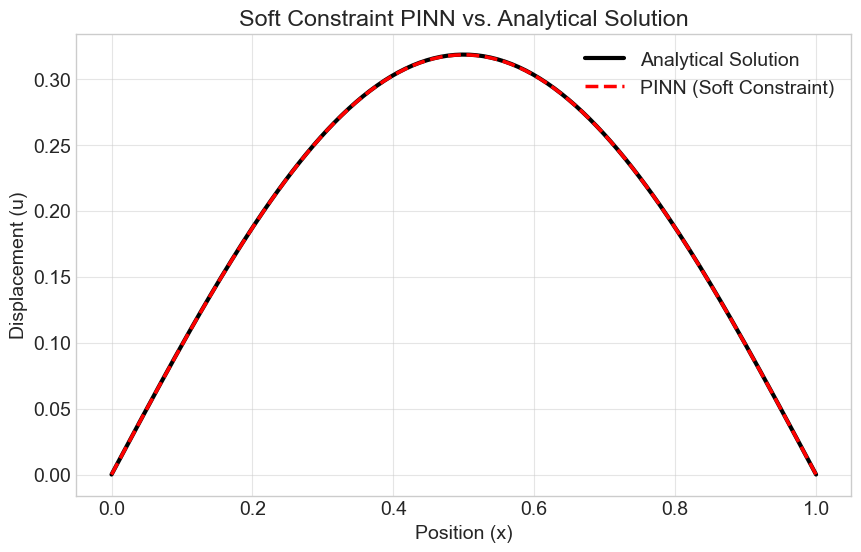

Predicted u(0): -3.2362e-05
Predicted u(1): -5.2180e-05


In [5]:
def train_pinn_soft(model, epochs=15000, lr=0.001, lambda_bc=1000.0):
    """Trains the PINN using the soft constraint method."""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Collocation points
    n_interior = 500
    x_interior = torch.rand(n_interior, 1, device=device)
    
    # Boundary points
    x_boundary = torch.tensor([[0.0], [1.0]], device=device)
    
    print(f"\n--- Training Soft-Constraint PINN (lambda_bc = {lambda_bc}) ---")
    losses = {'total': [], 'pde': [], 'boundary': []}
    
    pbar = tqdm(range(epochs), desc="Training Soft-Constraint PINN", ncols=100)
    for epoch in pbar:
        optimizer.zero_grad()
        
        # Compute losses
        loss_pde = pde_loss(model, x_interior)
        loss_bc = boundary_loss(model, x_boundary)
        
        # Total loss
        total_loss = loss_pde + lambda_bc * loss_bc
        
        # Backpropagation
        total_loss.backward()
        optimizer.step()
        
        # Store and display losses
        losses['total'].append(total_loss.item())
        losses['pde'].append(loss_pde.item())
        losses['boundary'].append(loss_bc.item())
        pbar.set_postfix({
            'Loss': f'{total_loss.item():.2e}',
            'PDE': f'{loss_pde.item():.2e}',
            'BC': f'{loss_bc.item():.2e}'
        })
        
    pbar.close()
    return model, losses

# Instantiate and train the soft-constraint model
pinn_soft = PINN().to(device)
pinn_soft_trained, losses_soft = train_pinn_soft(pinn_soft)

# Get predictions
pinn_soft_trained.eval()
with torch.no_grad():
    u_pred_soft = pinn_soft_trained(x_test).cpu().numpy()

# Plot results for the soft-constraint model
plt.figure(figsize=(10, 6))
plt.plot(x_test_np, u_true_np, 'k-', label='Analytical Solution', linewidth=3)
plt.plot(x_test_np, u_pred_soft, 'r--', label='PINN (Soft Constraint)', linewidth=2.5)
plt.title('Soft Constraint PINN vs. Analytical Solution')
plt.xlabel('Position (x)')
plt.ylabel('Displacement (u)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# Check boundary values
print(f"Predicted u(0): {u_pred_soft[0][0]:.4e}")
print(f"Predicted u(1): {u_pred_soft[-1][0]:.4e}")


As we can see, the soft constraint approach produces a very accurate solution. However, the predicted values at the boundaries are not exactly zero, but very small numbers. This is the nature of soft enforcement—it gets close, but not perfect, depending on the loss weight and training.



### **Stage 2: The Hard Constraint Approach (Strong Enforcement)**

An alternative to penalty terms is to enforce the boundary conditions *by construction*. This is known as the "hard" or "strong" method.

**How it works:**
We redefine the network's output to create a "trial solution" $\tilde{u}(x)$ that is mathematically guaranteed to satisfy the Dirichlet boundary conditions, regardless of the neural network's raw output.

For our problem with BCs $u(0)=0$ and $u(1)=0$, a suitable trial solution is:
$$\tilde{u}(x) = D(x) \cdot \text{NN}(x; \theta)$$
where $\text{NN}(x; \theta)$ is the output of a standard neural network and $D(x)$ is a function that is zero at the boundaries. A simple and effective choice is:
$$D(x) = x(1-x)$$
Our new model's output is $\tilde{u}(x) = x(1-x)\text{NN}(x; \theta)$.

  * At $x=0$, $\tilde{u}(0) = 0 \cdot (1-0) \cdot \text{NN}(0) = 0$.
  * At $x=1$, $\tilde{u}(1) = 1 \cdot (1-1) \cdot \text{NN}(1) = 0$.

The BCs are now satisfied exactly. The training process simplifies significantly, as the **loss function now only contains the PDE residual term**. We no longer need a boundary loss or a weighting hyperparameter.

#### **PINN Definition for Hard Constraints**

We create a new model that wraps our original `PINN` and applies the hard constraint transformation.

In [ ]:
class PINNHardConstraint(nn.Module):
    """PINN that enforces u(0)=0 and u(1)=0 by construction."""
    def __init__(self, base_network):
        super(PINNHardConstraint, self).__init__()
        self.base_network = base_network

    def forward(self, x):
        # Raw output from the base network
        nn_output = self.base_network(x)
        
        # Enforce u(0)=0 and u(1)=0
        # D(x) = x * (1 - x)
        # u_trial(x) = D(x) * NN(x)
        
        
        return u_trial

#### **Training the Hard-Constraint PINN**

The training loop is now simpler, with only the PDE loss to minimize.



--- Training Hard-Constraint PINN ---


Training Hard-Constraint PINN: 100%|██████| 15000/15000 [01:36<00:00, 154.90it/s, PDE Loss=1.55e-05]


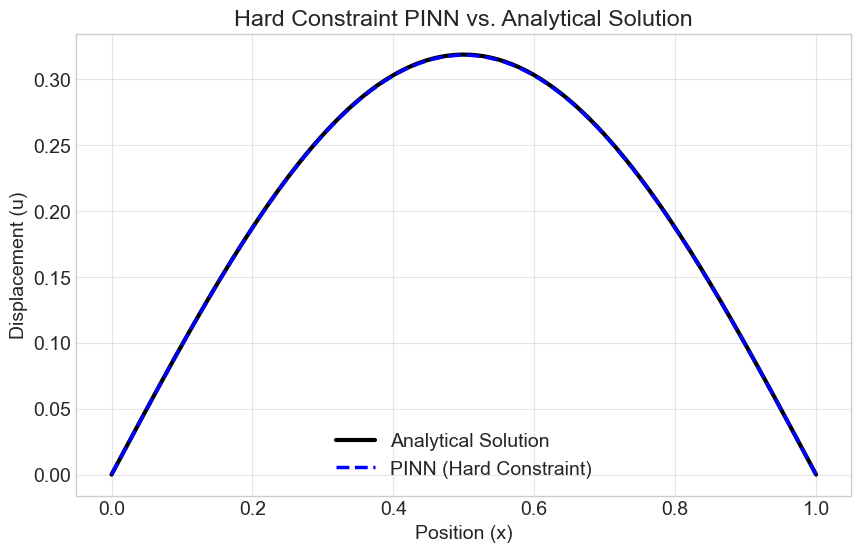

Predicted u(0): 0.0000e+00
Predicted u(1): 0.0000e+00


In [7]:
def train_pinn_hard(model, epochs=15000, lr=0.001):
    """Trains the PINN using the hard constraint method."""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Collocation points
    n_interior = 500
    x_interior = torch.rand(n_interior, 1, device=device)
    
    print("\n--- Training Hard-Constraint PINN ---")
    losses = {'pde': []}
    
    pbar = tqdm(range(epochs), desc="Training Hard-Constraint PINN", ncols=100)
    for epoch in pbar:
        optimizer.zero_grad()
        
        # Compute loss (only PDE loss is needed)
        loss_pde = pde_loss(model, x_interior)
        
        # Backpropagation
        loss_pde.backward()
        optimizer.step()
        
        # Store and display loss
        losses['pde'].append(loss_pde.item())
        pbar.set_postfix({'PDE Loss': f'{loss_pde.item():.2e}'})
        
    pbar.close()
    return model, losses

# Instantiate the base network and the hard-constraint wrapper
base_pinn = PINN().to(device)
pinn_hard = PINNHardConstraint(base_pinn).to(device)

# Train the hard-constraint model
pinn_hard_trained, losses_hard = train_pinn_hard(pinn_hard)

# Get predictions
pinn_hard_trained.eval()
with torch.no_grad():
    u_pred_hard = pinn_hard_trained(x_test).cpu().numpy()

# Plot results for the hard-constraint model
plt.figure(figsize=(10, 6))
plt.plot(x_test_np, u_true_np, 'k-', label='Analytical Solution', linewidth=3)
plt.plot(x_test_np, u_pred_hard, 'b--', label='PINN (Hard Constraint)', linewidth=2.5)
plt.title('Hard Constraint PINN vs. Analytical Solution')
plt.xlabel('Position (x)')
plt.ylabel('Displacement (u)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# Check boundary values
print(f"Predicted u(0): {u_pred_hard[0][0]:.4e}")
print(f"Predicted u(1): {u_pred_hard[-1][0]:.4e}")

With the hard constraint, the predicted values at the boundaries are exactly zero, as expected from the design.


### **Stage 3: Comparison and Analysis**

Now let's directly compare the performance of the soft and hard constraint methods.

#### **Solution and Error Comparison**

We plot both PINN solutions against the analytical solution and also visualize their absolute errors.

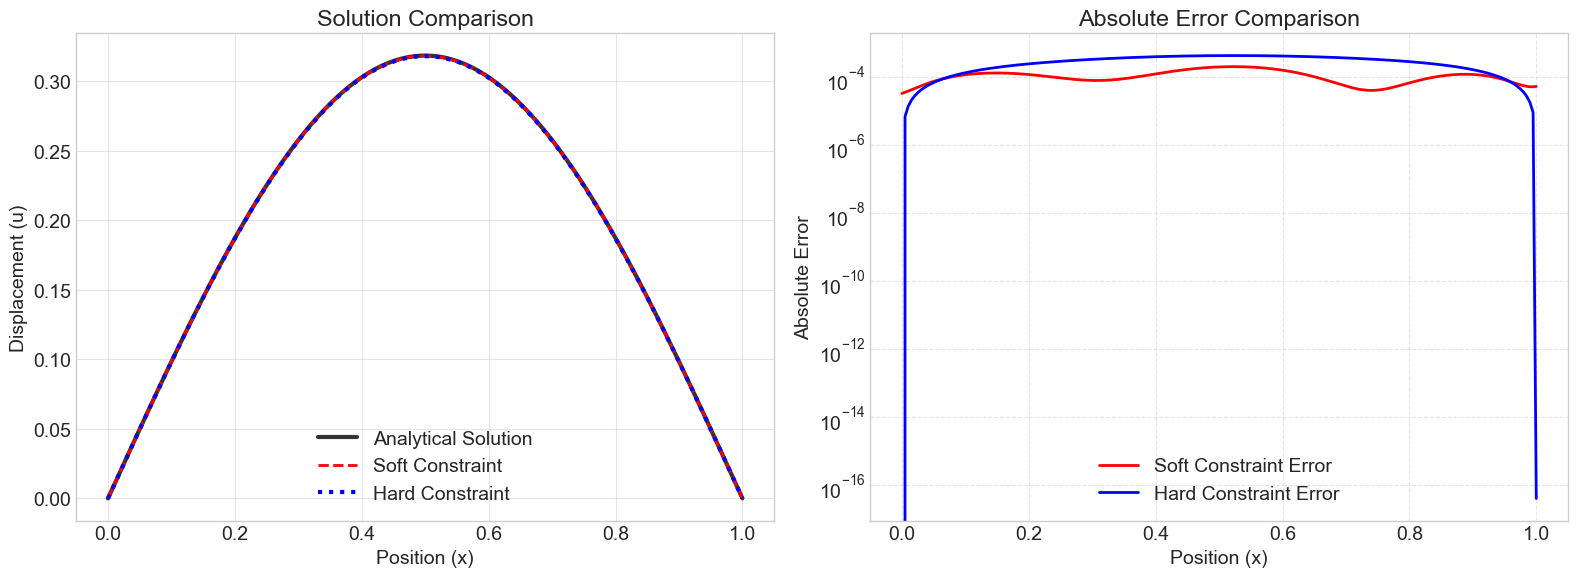

--- Quantitative Comparison ---
Method             | RMSE      | u(0) Value | u(1) Value
-------------------|-----------|------------|-----------
Soft Constraint    | 1.150e-04 | -3.236e-05  | -5.218e-05
Hard Constraint    | 3.011e-04 | 0.000e+00 | 0.000e+00


In [8]:
# Calculate absolute errors
error_soft = np.abs(u_pred_soft - u_true_np.reshape(-1, 1))
error_hard = np.abs(u_pred_hard - u_true_np.reshape(-1, 1))

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Solution Comparison
ax1.plot(x_test_np, u_true_np, 'k-', label='Analytical Solution', linewidth=3, alpha=0.8)
ax1.plot(x_test_np, u_pred_soft, 'r--', label='Soft Constraint', linewidth=2)
ax1.plot(x_test_np, u_pred_hard, 'b:', label='Hard Constraint', linewidth=3)
ax1.set_title('Solution Comparison')
ax1.set_xlabel('Position (x)')
ax1.set_ylabel('Displacement (u)')
ax1.legend()
ax1.grid(True, alpha=0.5)

# Plot 2: Absolute Error Comparison
ax2.plot(x_test_np, error_soft, 'r-', label='Soft Constraint Error', linewidth=2)
ax2.plot(x_test_np, error_hard, 'b-', label='Hard Constraint Error', linewidth=2)
ax2.set_title('Absolute Error Comparison')
ax2.set_xlabel('Position (x)')
ax2.set_ylabel('Absolute Error')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Quantitative Error Metrics
rmse_soft = np.sqrt(np.mean(error_soft**2))
rmse_hard = np.sqrt(np.mean(error_hard**2))
u0_soft = u_pred_soft[0][0]
u1_soft = u_pred_soft[-1][0]
u0_hard = u_pred_hard[0][0]
u1_hard = u_pred_hard[-1][0]

print("--- Quantitative Comparison ---")
print(f"Method             | RMSE      | u(0) Value | u(1) Value")
print("-------------------|-----------|------------|-----------")
print(f"Soft Constraint    | {rmse_soft:.3e} | {u0_soft:.3e}  | {u1_soft:.3e}")
print(f"Hard Constraint    | {rmse_hard:.3e} | {u0_hard:.3e} | {u1_hard:.3e}")


#### **Discussion of Results**

Both methods achieve a high degree of accuracy for this problem. The hard constraint method shows a slightly lower overall error (RMSE) and, by design, has zero error at the boundaries.

**Trade-offs:**

  * **Soft Constraints (Weak Enforcement):**

      * **Pros:** Very flexible. The same approach can be used for different types of boundary conditions (Dirichlet, Neumann, Robin) without changing the network architecture. It's easy to implement.
      * **Cons:** Requires careful tuning of the loss weight ($\lambda\_{BC}$). If the weight is too small, the BCs are not well-enforced. If it's too large, it can dominate the optimization and hinder convergence of the PDE part. Satisfaction of BCs is only approximate.

  * **Hard Constraints (Strong Enforcement):**

      * **Pros:** Guarantees exact satisfaction of Dirichlet BCs. Simplifies the loss function, removing the need to balance competing PDE and BC loss terms, which can lead to more stable and faster training.
      * **Cons:** Less flexible. It requires designing a specific trial function $\tilde{u}(x)$ for the exact geometry and boundary conditions of the problem. This can become very difficult or impossible for complex domains or more complicated BCs.

For problems with simple geometries and Dirichlet boundary conditions, the **hard constraint method is often the superior choice** due to its robustness and simplified training dynamics. For problems with complex geometries or other types of boundary conditions, the **soft constraint method provides a more versatile and straightforward framework**